In [4]:
import yaml
import numpy as np
import zstandard as zstd
import os
from OptimumFilter import *
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
sub_template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)
vac_of = OptimumFilter(vac_template, noise_psd, sampling_frequency)
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

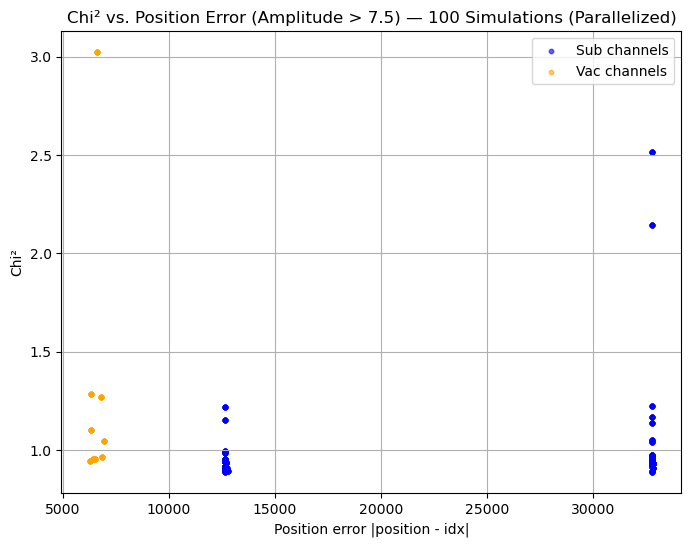

In [ ]:
import matplotlib.pyplot as plt
import concurrent.futures

# Shared result lists (to be filled by workers)
sub_deltas = []
sub_chisqs = []
vac_deltas = []
vac_chisqs = []

def process_one_simulation(_):
    trace_batch, idx = lts.generate(
        E=7000,
        x=-94, y=0, z=-1800,
        no_noise=False,
        type_recoil='ER',
        quantize=True,
        phonon_only=False
    )
    trace = trace_batch[0]
    
    local_sub_deltas = []
    local_sub_chisqs = []
    local_vac_deltas = []
    local_vac_chisqs = []

    for ch in range(54):
        if ch < 45:
            ampl, chisq, shift, position = sub_of.rolling_fit_with_shift(trace[ch])
        else:
            ampl, chisq, shift, position = vac_of.rolling_fit_with_shift(trace[ch])
        
        for a, s, c, p in zip(ampl, shift, chisq, position):
            if a > 7.5:
                delta = abs(p - idx)
                if ch < 45:
                    local_sub_deltas.append(delta)
                    local_sub_chisqs.append(c)
                else:
                    local_vac_deltas.append(delta)
                    local_vac_chisqs.append(c)

    return local_sub_deltas, local_sub_chisqs, local_vac_deltas, local_vac_chisqs


# Run in parallel with 10 workers
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_one_simulation, range(100)))

# Aggregate results
for sub_d, sub_c, vac_d, vac_c in results:
    sub_deltas.extend(sub_d)
    sub_chisqs.extend(sub_c)
    vac_deltas.extend(vac_d)
    vac_chisqs.extend(vac_c)

# ---- Plot ----
plt.figure(figsize=(8, 6))
plt.scatter(sub_deltas, sub_chisqs, alpha=0.6, label='Sub channels', color='blue', s=10)
plt.scatter(vac_deltas, vac_chisqs, alpha=0.6, label='Vac channels', color='orange', s=10)
plt.xlabel("Position error |position - idx|")
plt.ylabel("Chi²")
plt.title("Chi² vs. Position Error (Amplitude > 7.5) — 100 Simulations (Parallelized)")
plt.grid(True)
plt.legend()
plt.show()
